<a href="https://colab.research.google.com/github/darthwaydr007/attention-experiments/blob/main/fully_convolutional_change_detection_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [70]:
#!gdown https://drive.google.com/uc?id=1JV-_VxTaIcE3hIfmo10I3VPqkibHpuUp

In [71]:
#!unzip "/content/crop_256.zip" -d "/content/sample_data"

In [72]:
#!pip install catalyst==20.12
#from catalyst.contrib.nn import DiceLoss, IoULoss


In [73]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr

# Other
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import time
import warnings
from pprint import pprint



print('IMPORTS OK')


IMPORTS OK


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import IMG_EXTENSIONS
from PIL import Image
from torchvision.transforms import ToTensor
import math
import torch.utils.model_zoo as model_zoo

scaler = torch.cuda.amp.GradScaler() 
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU')
    device = torch.device("cpu")

There are 1 GPU available.
GPU: Tesla V100-SXM2-16GB


In [75]:
# Global Variables' Definitions

PATH_TO_DATASET = './OSCD/'
IS_PROTOTYPE = False

FP_MODIFIER = 10 # Tuning parameter, use 1 if unsure
1
PATCH_SIDE = 96
N_EPOCHS = 10

NORMALISE_IMGS = True

TRAIN_STRIDE = int(PATCH_SIDE/2) - 1
# 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

LOAD_TRAINED = False

DATA_AUG = True


print('DEFINITIONS OK')

DEFINITIONS OK


## Images

In [76]:
import glob 
img_path_A = glob.glob("/content/sample_data/crop_256/train/A/*.png")
img_path_B = glob.glob("/content/sample_data/crop_256/train/B/*.png")
mask_path = glob.glob("/content/sample_data/crop_256/train/label/*.png")

In [77]:
img_path_A_valid = glob.glob("/content/sample_data/crop_256/val/A/*.png")
img_path_B_valid = glob.glob("/content/sample_data/crop_256/val/B/*.png")
mask_path_valid = glob.glob("/content/sample_data/crop_256/val/label/*.png")

In [78]:
img_path_A_test = glob.glob("/content/sample_data/crop_256/test/A/*.png")
img_path_B_test = glob.glob("/content/sample_data/crop_256/test/B/*.png")
mask_path_test = glob.glob("/content/sample_data/crop_256/test/label/*.png")

In [79]:
imageA = Image.open(img_path_A[0])
imageB = Image.open(img_path_B[0])
mask = Image.open(mask_path[0])

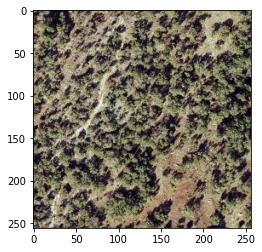

In [80]:
plt.figure()
plt.imshow(imageA) 
plt.show()

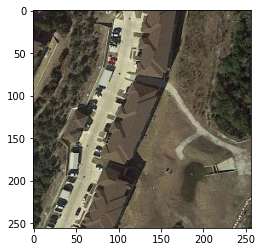

In [81]:
plt.figure()
plt.imshow(imageB) 
plt.show()

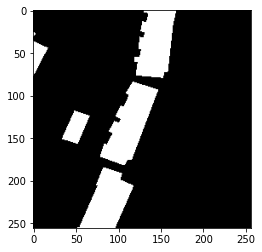

In [82]:
plt.figure()
plt.imshow(mask) 
plt.show()

In [83]:
len(img_path_A)

7120

In [84]:
imageA.size

(256, 256)

## Dataset

In [85]:
BATCH_SIZE = 32

In [86]:
img_dim=256

In [87]:
class LEVIRDataset(Dataset):
  def __init__(self , img_path_A, img_path_B, mask_path):
    self.img_path_A = img_path_A
    self.img_path_B = img_path_B
    self.mask_path = mask_path
    self.length = len(self.img_path_A)
    self.transforms = transforms.Compose([
                                          transforms.ToTensor()])

  def __len__(self):
    return self.length

  def __getitem__(self , index):   
    

    return {
        'imgA' : self.transforms(Image.open(self.img_path_A[index])) , 
        'imgB' : self.transforms(Image.open(self.img_path_B[index])) ,
        'mask' : self.transforms(Image.open(self.mask_path[index])) , 
    }


In [88]:
train_dataset = LEVIRDataset(img_path_A ,img_path_B, mask_path)
train_loader = torch.utils.data.DataLoader(train_dataset , batch_size = BATCH_SIZE, shuffle = False , drop_last=True)

In [89]:
valid_dataset = LEVIRDataset(img_path_A_valid ,img_path_B_valid, mask_path_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset , batch_size = BATCH_SIZE, shuffle = False , drop_last=True)

In [90]:
test_dataset = LEVIRDataset(img_path_A_test ,img_path_B_test, mask_path_test)
test_loader = torch.utils.data.DataLoader(test_dataset , batch_size = BATCH_SIZE, shuffle = False , drop_last=True)

In [91]:
len(test_loader)

64

## Test

In [92]:
dataiter = iter(train_loader)
out = dataiter.next()

In [93]:
imgA = out['imgA']
imgB = out['imgB']
mask1 = out['mask']
imgA.shape


torch.Size([32, 3, 256, 256])

In [94]:
label = torch.cat((1-mask1[:,0:1,:,:],mask1[:,0:1,:,:]), dim =1)
label.shape

torch.Size([32, 2, 256, 256])

In [95]:
b=10

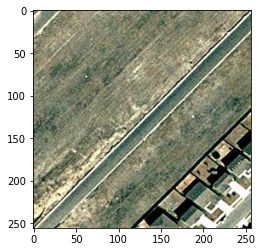

In [96]:
plt.imshow(np.transpose(imgA[b].numpy(), (1, 2, 0)))

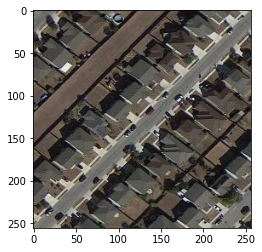

In [97]:
plt.imshow(np.transpose(imgB[b].numpy(), (1, 2, 0)))

In [98]:
mask2 = mask1.long()

In [99]:
mask2.unique()

tensor([0, 1])

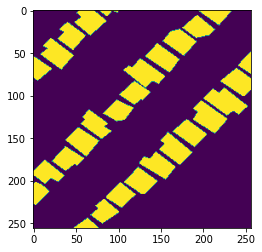

In [100]:
plt.imshow((mask2[b][1,:,:]))

## Model

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class SiamUnet_diff(nn.Module):
    """SiamUnet_diff segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_diff, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):


        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)

        ####################################################
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)



        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), torch.abs(x43_1 - x43_2)), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), torch.abs(x33_1 - x33_2)), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), torch.abs(x22_1 - x22_2)), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), torch.abs(x12_1 - x12_2)), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return x11d #self.sigmoid(x11d)


In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class SiamUnet_conc(nn.Module):
    """SiamUnet_conc segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_conc, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(384, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(192, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(96, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(48, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)


        ####################################################
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)


        ####################################################
        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43_1, x43_2), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33_1, x33_2), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22_1, x22_2), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12_1, x12_2), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)
        out = nn.Sigmoid(x11d)

        return x11d #self.sigmoid(x11d)


In [103]:
from torch.nn.modules.padding import ReplicationPad2d

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1)


class BasicBlock_ss(nn.Module):

    def __init__(self, inplanes, planes = None, subsamp=1):
        super(BasicBlock_ss, self).__init__()
        if planes == None:
            planes = inplanes * subsamp
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.subsamp = subsamp
        self.doit = planes != inplanes
        if self.doit:
            self.couple = nn.Conv2d(inplanes, planes, kernel_size=1)
            self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        if self.doit:
            residual = self.couple(x)
            residual = self.bnc(residual)
        else:
            residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        if self.subsamp > 1:
            out = F.max_pool2d(out, kernel_size=self.subsamp, stride=self.subsamp)
            residual = F.max_pool2d(residual, kernel_size=self.subsamp, stride=self.subsamp)

        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu(out)

        return out
    

    
class BasicBlock_us(nn.Module):

    def __init__(self, inplanes, upsamp=1):
        super(BasicBlock_us, self).__init__()
        planes = int(inplanes / upsamp) # assumes integer result, fix later
        self.conv1 = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsamp = upsamp
        self.couple = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1) 
        self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = self.couple(x)
        residual = self.bnc(residual)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out
    
    
class FresUNet(nn.Module):
    """FresUNet segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        """Init FresUNet fields."""
        super(FresUNet, self).__init__()

        self.input_nbr = input_nbr
        
        cur_depth = input_nbr
        
        base_depth = 16
        
        # Encoding stage 1
        self.encres1_1 = BasicBlock_ss(cur_depth, planes = base_depth)
        cur_depth = base_depth
        d1 = base_depth
        self.encres1_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 2
        self.encres2_1 = BasicBlock_ss(cur_depth)
        d2 = cur_depth
        self.encres2_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 3
        self.encres3_1 = BasicBlock_ss(cur_depth)
        d3 = cur_depth
        self.encres3_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 4
        self.encres4_1 = BasicBlock_ss(cur_depth)
        d4 = cur_depth
        self.encres4_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Decoding stage 4
        self.decres4_1 = BasicBlock_ss(cur_depth)
        self.decres4_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 3
        self.decres3_1 = BasicBlock_ss(cur_depth + d4, planes = cur_depth)
        self.decres3_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 2
        self.decres2_1 = BasicBlock_ss(cur_depth + d3, planes = cur_depth)
        self.decres2_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 1
        self.decres1_1 = BasicBlock_ss(cur_depth + d2, planes = cur_depth)
        self.decres1_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Output
        self.coupling = nn.Conv2d(cur_depth + d1, label_nbr, kernel_size=1)
        self.sm = nn.LogSoftmax(dim=1)
        
    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
#         pad5 = ReplicationPad2d((0, x53.size(3) - x5d.size(3), 0, x53.size(2) - x5d.size(2)))
        
        s1_1 = x.size()
        x1 = self.encres1_1(x)
        x = self.encres1_2(x1)
        
        s2_1 = x.size()
        x2 = self.encres2_1(x)
        x = self.encres2_2(x2)
        
        s3_1 = x.size()
        x3 = self.encres3_1(x)
        x = self.encres3_2(x3)
        
        s4_1 = x.size()
        x4 = self.encres4_1(x)
        x = self.encres4_2(x4)
        
        x = self.decres4_1(x)
        x = self.decres4_2(x)
        s4_2 = x.size()
        pad4 = ReplicationPad2d((0, s4_1[3] - s4_2[3], 0, s4_1[2] - s4_2[2]))
        x = pad4(x)
        
        # x = self.decres3_1(x)
        x = self.decres3_1(torch.cat((x, x4), 1))
        x = self.decres3_2(x)
        s3_2 = x.size()
        pad3 = ReplicationPad2d((0, s3_1[3] - s3_2[3], 0, s3_1[2] - s3_2[2]))
        x = pad3(x)
        
        x = self.decres2_1(torch.cat((x, x3), 1))
        x = self.decres2_2(x)
        s2_2 = x.size()
        pad2 = ReplicationPad2d((0, s2_1[3] - s2_2[3], 0, s2_1[2] - s2_2[2]))
        x = pad2(x)
        
        x = self.decres1_1(torch.cat((x, x2), 1))
        x = self.decres1_2(x)
        s1_2 = x.size()
        pad1 = ReplicationPad2d((0, s1_1[3] - s1_2[3], 0, s1_1[2] - s1_2[2]))
        x = pad1(x)
        
        x = self.coupling(torch.cat((x, x1), 1))
        #x = self.sm(x)
        
        return x

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class Unet(nn.Module):
    """EF segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(Unet, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)


        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x))))
        x12 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43, kernel_size=2, stride=2)


        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43.size(3) - x4d.size(3), 0, x43.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33.size(3) - x3d.size(3), 0, x33.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22.size(3) - x2d.size(3), 0, x22.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12.size(3) - x1d.size(3), 0, x12.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return x11d #self.sm(x11d)


## Optim

In [105]:
TYPE = 2

In [106]:
# 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

if TYPE == 0:
#     net, net_name = Unet(2*3, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
#     net, net_name = SiamUnet_diff(3, 2), 'FC-Siam-diff'
    model, model_name = FresUNet(2*3, 1), 'FresUNet1'
elif TYPE == 1:
#     net, net_name = Unet(2*4, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(4, 2), 'FC-Siam-conc'
#     net, net_name = SiamUnet_diff(4, 2), 'FC-Siam-diff'
    model, model_name = SiamUnet_diff(3, 2), 'SiamUnet_diff'
elif TYPE == 2:
#     net, net_name = Unet(2*10, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(10, 2), 'FC-Siam-conc'
#     net, net_name = SiamUnet_diff(10, 2), 'FC-Siam-diff'
    model, model_name = Unet(3*2, 2), 'Unet'
elif TYPE == 3:
#     net, net_name = Unet(2*13, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(13, 2), 'FC-Siam-conc'
#     net, net_name = SiamUnet_diff(13, 2), 'FC-Siam-diff'
    model, model_name = FresUNet(3*2, 2), 'FresUNet'



#criterion_aux = nn.NLLLoss() in# to be used with logsoftmax output

model_name

'Unet'

In [107]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [108]:
def meanIOU(target, predicted):
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    iousum = 0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        intersection = np.logical_and(target_arr, predicted_arr).sum()
        union = np.logical_or(target_arr, predicted_arr).sum()
        if union == 0:
            iou_score = 0
        else :
            iou_score = intersection / union
        iousum +=iou_score
        
    miou = iousum/target.shape[0]
    return miou

In [109]:
def pixelAcc(target, predicted):    
    if target.shape != predicted.shape:
        #print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        #print("target has dim", target.dim(), ", Must be 4.")
        return
    
    accsum=0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        same = (target_arr == predicted_arr).sum()
        a, b = target_arr.shape
        total = a*b
        accsum += same/total
    
    pixelAccuracy = accsum/target.shape[0]        
    return pixelAccuracy

In [110]:
def meanIOU_single(target, predicted):
    iousum = 0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :].clone().detach().cpu().numpy().argmax(0)
        
        intersection = np.logical_and(target_arr, predicted_arr).sum()
        union = np.logical_or(target_arr, predicted_arr).sum()
        
        iou_score = (intersection +1e-10) / (union+1e-10)
        iousum +=iou_score
        
    miou = iousum/target.shape[0]
    return miou

In [111]:
import numpy
sigmoid = nn.Sigmoid()

In [ ]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

model.to(device)

In [137]:

criterion = nn.CrossEntropyLoss()
LR = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.5, 0.999))#,weight_decay=1e-4)
n_epoch =10
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr= LR, steps_per_epoch=len(train_loader), epochs=n_epoch)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)



def count_parameters(model):
   return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(model))

Number of trainable parameters: 1350578


In [132]:
IOU_train = []
IOU_test = []
loss_claf = []

In [129]:
batches_train = len(train_loader)
batches_test = len(valid_loader)

## Train

======== Epoch 1 / 10 ========
IOU for image :  0.7978142076503837
label


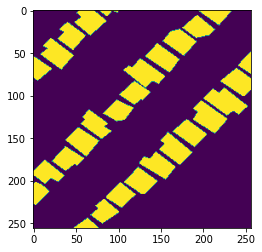

out 2


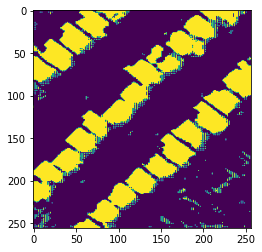

IOU for image :  1.0
label


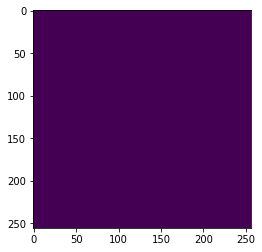

out 2


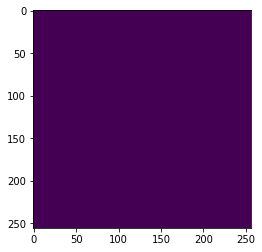

|| loss : 0.08207111805677414 
|| IOU : 0.6090266440739263 
Learning Rate 0: 0.0001
IOU for image :  0.9395973154362821
label


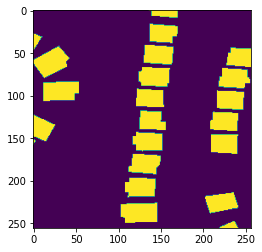

out 2


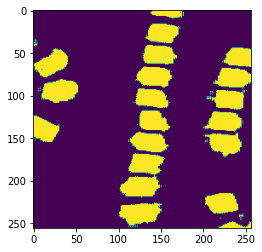

IOU for image :  1.0
label


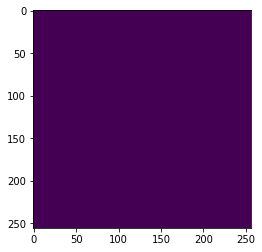

out 2


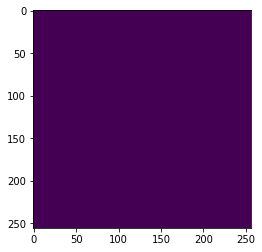

|| loss : 0.04613824561238289 
|| IOU : 0.582485170407983 
Learning Rate 0: 0.0001
IOU for image :  0.7176470588238616
label


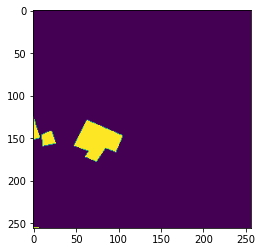

out 2


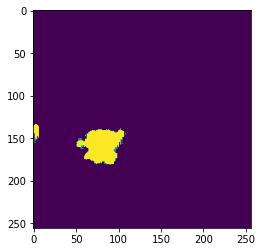

|| loss : 0.029151929542422295 
|| IOU : 0.7851868325349043 
Learning Rate 0: 0.0001
IOU for image :  1.666666666638889e-11
label


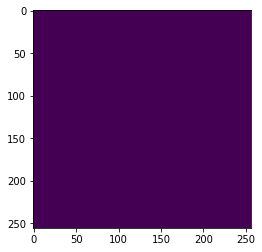

out 2


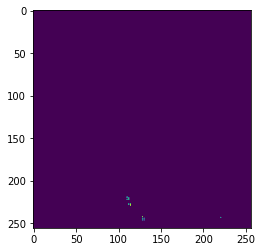

IOU for image :  1.0
label


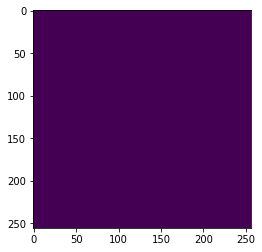

out 2


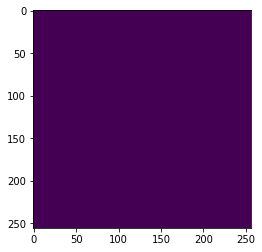

|| loss : 0.039996691048145294 
|| IOU : 0.7222717608513075 
Learning Rate 0: 0.0001
IOU for image :  2.5641025640959895e-12
label


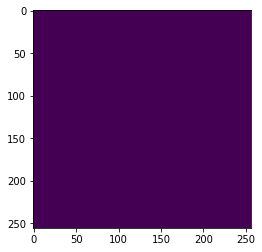

out 2


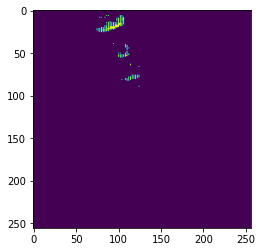

|| loss : 0.04747952148318291 
|| IOU : 0.7898806814711415 
Learning Rate 0: 0.0001
IOU for image :  1.0
label


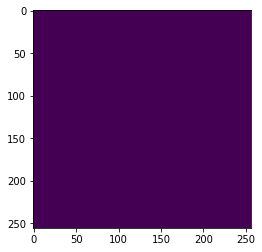

out 2


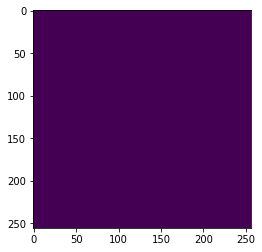

0.0001
IOU Train:  0.7047
IOU test batch : 0.7055196058737079
IOU for image test :  0.8705882352942699
label


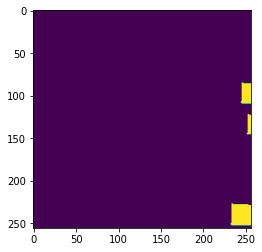

out 2


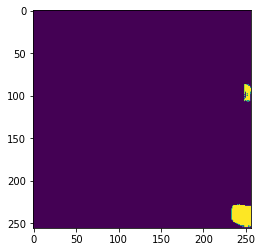

IOU test batch : 0.8074064922727734
IOU for image test :  0.9532163742690332
label


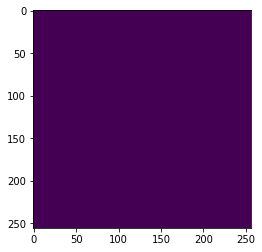

out 2


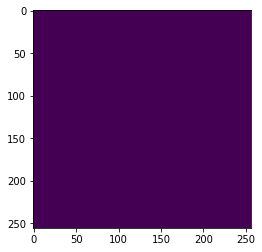

IOU Train:  0.7047
IOU Testing :  0.7805
======== Epoch 2 / 10 ========
|| loss : 0.07078196853399277 
|| IOU : 0.6062835586811517 
Learning Rate 0: 9.5e-05
|| loss : 0.03829358518123627 
|| IOU : 0.5224262460682036 
Learning Rate 0: 9.5e-05
|| loss : 0.027006201446056366 
|| IOU : 0.911459496271452 
Learning Rate 0: 9.5e-05
|| loss : 0.04134184867143631 
|| IOU : 0.6468415285607872 
Learning Rate 0: 9.5e-05
|| loss : 0.05429926887154579 
|| IOU : 0.6974568910550674 
Learning Rate 0: 9.5e-05
9.5e-05
IOU Train:  0.6942
IOU Train:  0.6942
IOU Testing :  0.7788
======== Epoch 3 / 10 ========
|| loss : 0.07130279392004013 
|| IOU : 0.7439777432678448 
Learning Rate 0: 9.025e-05
|| loss : 0.062406331300735474 
|| IOU : 0.3601757431387325 
Learning Rate 0: 9.025e-05
|| loss : 0.029413241893053055 
|| IOU : 0.7164398593675569 
Learning Rate 0: 9.025e-05
|| loss : 0.039801258593797684 
|| IOU : 0.7036043288492556 
Learning Rate 0: 9.025e-05
|| loss : 0.04587921127676964 
|| IOU : 0.74340864434

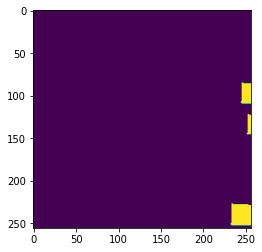

out 2


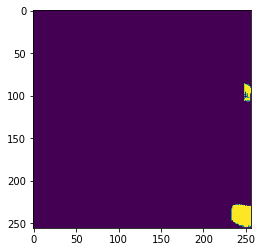

IOU test batch : 0.8398440361970846
IOU for image test :  0.959064327485404
label


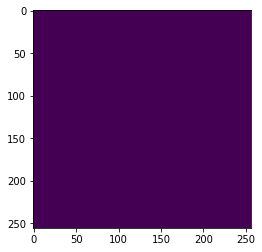

out 2


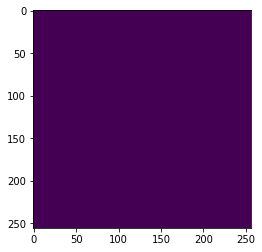

IOU Train:  0.7054
IOU Testing :  0.7787
======== Epoch 5 / 10 ========
IOU for image :  0.8009049773756557
label


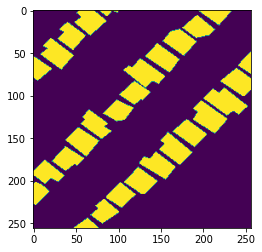

out 2


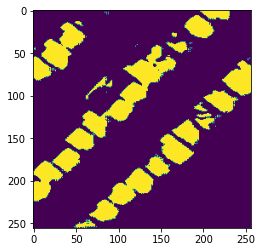

IOU for image :  1.0
label


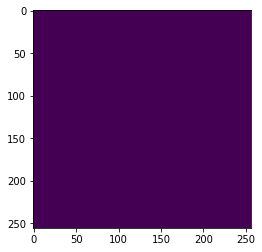

out 2


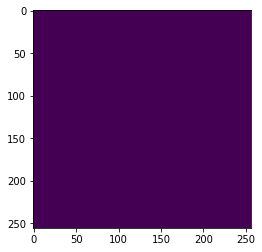

|| loss : 0.07872568815946579 
|| IOU : 0.6246866135480222 
Learning Rate 0: 8.145062499999998e-05
IOU for image :  0.94000000000004
label


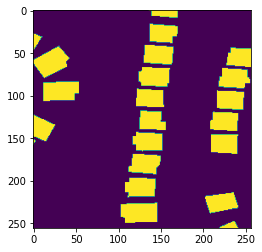

out 2


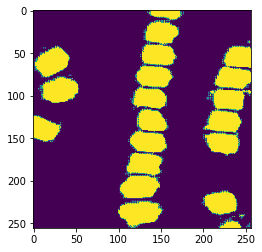

IOU for image :  1.0
label


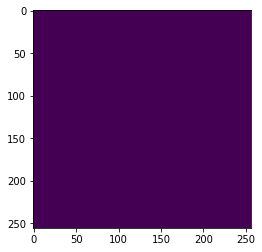

out 2


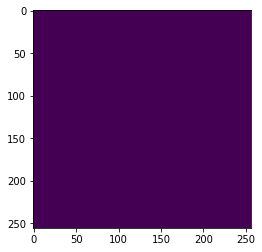

|| loss : 0.05304337665438652 
|| IOU : 0.4734767285321899 
Learning Rate 0: 8.145062499999998e-05
IOU for image :  0.6097560975614515
label


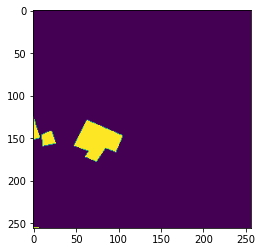

out 2


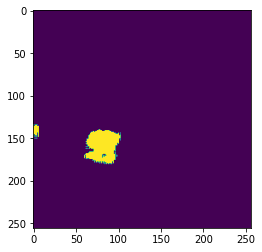

|| loss : 0.035134147852659225 
|| IOU : 0.7745206469570072 
Learning Rate 0: 8.145062499999998e-05
IOU for image :  1.0
label


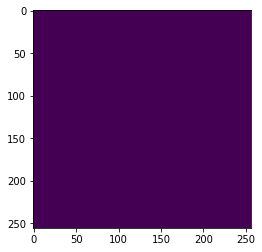

out 2


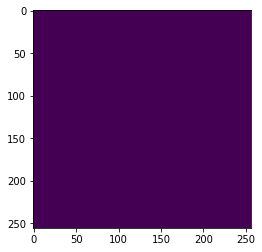

IOU for image :  1.4285714285510204e-11
label


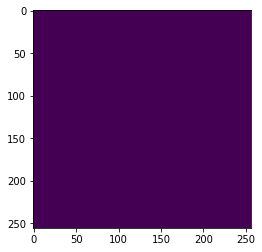

out 2


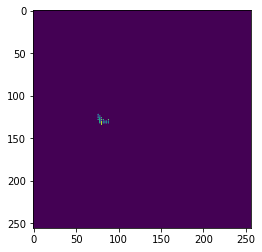

|| loss : 0.04238177835941315 
|| IOU : 0.7029200084273659 
Learning Rate 0: 8.145062499999998e-05
IOU for image :  2.222222222217284e-12
label


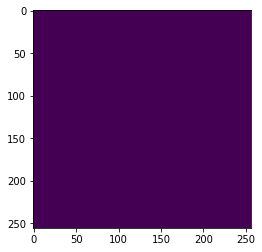

out 2


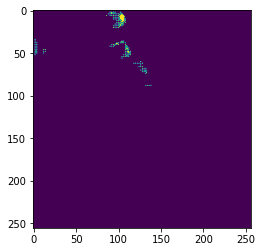

|| loss : 0.05087173730134964 
|| IOU : 0.7719292889381606 
Learning Rate 0: 8.145062499999998e-05
IOU for image :  1.0
label


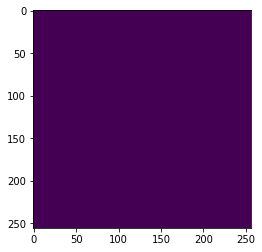

out 2


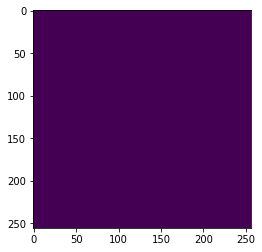

8.145062499999998e-05
IOU Train:  0.7059
IOU Train:  0.7059
IOU Testing :  0.7844
======== Epoch 6 / 10 ========
|| loss : 0.07290902733802795 
|| IOU : 0.6553584268688059 
Learning Rate 0: 7.737809374999998e-05
|| loss : 0.05122081935405731 
|| IOU : 0.5145932720366647 
Learning Rate 0: 7.737809374999998e-05
|| loss : 0.028220854699611664 
|| IOU : 0.8211625616999213 
Learning Rate 0: 7.737809374999998e-05


In [ ]:
#scaler = torch.cuda.amp.GradScaler()
for epoch in range(0, n_epoch): 
   # if epoch % 5 == 0:
   #   LR = LR/2
   #   optimizer = optim.Adam(classifier.parameters(), lr = LR, betas=(0.5, 0.999))
    #epochs.append(epoch)
    #=======================Train=======================#
    model.train()
    iou = 0
    iou1 = 0
    #iou1 = 0
    print('======== Epoch {:} / {:} ========'.format(epoch+1, n_epoch))          
    #D_losses, G_losses = [], []
    for batch_idx, out in enumerate(train_loader):
      
        optimizer.zero_grad()
        #classifier.zero_grad()
        imgA = out['imgA']
        imgB = out['imgB']
        mask1 = out['mask']
        mask2 = mask1.long()
        label = mask1[:,0,:,:]
        label[label>0] = 1
        
        label = label.long()

        label1 = torch.cat((1-mask1[:,0:1,:,:],mask1[:,0:1,:,:]), dim =1)
        label2 = torch.cat((mask1[:,0:1,:,:],1-mask1[:,0:1,:,:]), dim =1)
        labelx = mask1[:,0,:,:]
        
        output = model(imgA.cuda() , imgB.cuda())
        loss = criterion(output , label.cuda())
        loss.backward()
        optimizer.step()

        new_loss = loss.item() 
        loss_claf.append(new_loss) 

        preds = sigmoid(output)
        
        preds[preds>=0.5] = 1
        preds[preds<0.5] = 0
        
        temp2 = meanIOU_single(labelx, preds[:,1,:,:])
        temp_iou = meanIOU(label1[:,1:,:,:], preds[:,1:,:,:])
        iou = iou + temp_iou
        iou1 = iou1 + temp2
        pixel = pixelAcc(label1, preds)


        if batch_idx % 40 == 0 and not batch_idx == 0: 

          print('|| loss : {:} '.format(loss.mean().item())) 
          #print('|| IOU NEW: {:} '.format(temp_iou)) 
          print('|| IOU : {:} '.format(temp2))
          print('Learning Rate 0:',optimizer.param_groups[0]['lr'])
          #print('Learning Rate 1:',optimizer.param_groups[1]['lr'])
          #print('|| IOU_2 : {:} '.format(temp2))
          #print('|| Pixel : {:} '.format(pixel))
          print('=====================================================')
          
        if batch_idx % 25 ==0 and epoch % 4 ==0 :
          print('IOU for image : ', meanIOU_single(labelx[10:11,:,:], preds[10:11,1,:,:]))
          print('label')
          plt.figure()
          plt.imshow(label[10]) 
          plt.show()
          print('out 2')
          plt.figure()
          plt.imshow(preds[10][1,:,:].detach().cpu().numpy()) 
          plt.show()
          #print(meanIOU(target, predicted))
    print(optimizer.param_groups[0]['lr'])
    scheduler.step()      
    iou1 = iou1/batches_train
    IOU_train.append(iou1)
    print('IOU Train: ' , round(iou1 , 4))
    #print('IOU Train-1: ' , round(iou1/batches_train , 4))
    #print('IOU Train: ' , round(iou1 , 4))

    #=======================Test=======================#    
    if epoch % 1 == 0:
      iou_test = 0
      iou_test1 = 0
      model.eval()
      with torch.no_grad():
        for batch_idx, out in enumerate(valid_loader):
          imgA = out['imgA']
          imgB = out['imgB']
          mask1 = out['mask']
          labelx= mask1[:,0,:,:]
          label1 = torch.cat((1-mask1[:,0:1,:,:],mask1[:,0:1,:,:]), dim =1)
          output = model(imgA.cuda() , imgB.cuda())
          preds = sigmoid(output)
          preds[preds>=0.5] = 1
          preds[preds<0.5] = 0
          #temp_iou = meanIOU(label1, preds)
          temp2 = meanIOU_single(labelx, preds[:,1,:,:])
          #iou_test = iou_test + temp_iou
          iou_test1 = iou_test1 + temp2
          label = mask1[:,0,:,:]
          label[label>0] = 1      
          label = label.long()
          if batch_idx % 23 ==0 and epoch % 3 ==0:
            print('IOU test batch :', temp2)
            print('IOU for image test : ', meanIOU_single(labelx[1:2,:,:], preds[1:2,1,:,:]))
            print('label')
            plt.figure()
            plt.imshow(label[8]) 
            plt.show()
            print('out 2')
            plt.figure()
            plt.imshow(preds[8][1,:,:].detach().cpu().numpy()) 
            plt.show()
              
      IOU_test.append(iou_test1/batches_test)
      print('=================================================')
      print('IOU Train: ' , round(iou1 , 4))
      print('IOU Testing : ' , round(iou_test1/batches_test , 4))
      print('=================================================')

In [ ]:
x1 = IOU_train
x2 = IOU_test

plt.plot(x1  , label = 'train')
plt.plot(x2  ,  label = 'test')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
Iou_test = 0

IOU test batch : 0.9310761805285035
IOU for image test :  1.0
label


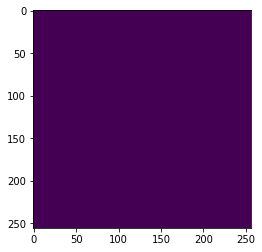

out 2


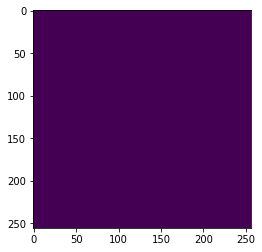

IOU test batch : 0.8831997436809154
IOU for image test :  0.9074074074075789
label


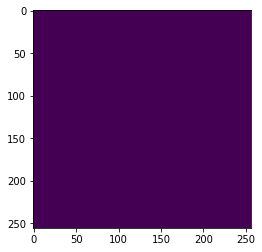

out 2


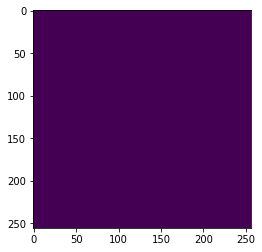

IOU test batch : 0.7427857959610591
IOU for image test :  1.5624999999975587e-12
label


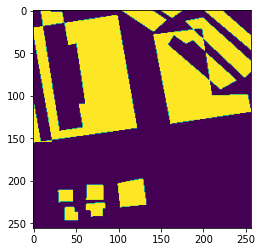

out 2


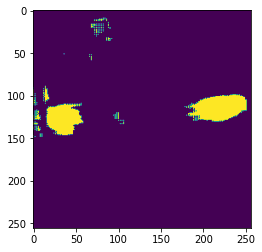

iou test 0.8117986572006677


In [136]:
model.eval()
with torch.no_grad():
    for batch_idx, out in enumerate(test_loader):
      imgA = out['imgA']
      imgB = out['imgB']
      mask1 = out['mask']
      labelx= mask1[:,0,:,:]
      label1 = torch.cat((1-mask1[:,0:1,:,:],mask1[:,0:1,:,:]), dim =1)
      output = model(imgA.cuda() , imgB.cuda())
      preds = sigmoid(output)
      preds[preds>=0.5] = 1
      preds[preds<0.5] = 0
      #temp_iou = meanIOU(label1, preds)
      temp2 = meanIOU_single(labelx, preds[:,1,:,:])
      #iou_test = iou_test + temp_iou
      Iou_test = Iou_test + temp2
      label = mask1[:,0,:,:]
      label[label>0] = 1      
      label = label.long()
      if batch_idx % 23 ==0 and epoch % 3 ==0:
        print('IOU test batch :', temp2)
        print('IOU for image test : ', meanIOU_single(labelx[1:2,:,:], preds[1:2,1,:,:]))
        print('label')
        plt.figure()
        plt.imshow(label[8]) 
        plt.show()
        print('out 2')
        plt.figure()
        plt.imshow(preds[8][1,:,:].detach().cpu().numpy()) 
        plt.show()
print('iou test' , Iou_test/len(test_loader))

In [119]:
# net.load_state_dict(torch.load('net-best_epoch-1_fm-0.7394933126157746.pth.tar'))

def train(n_epochs = N_EPOCHS, save = True):
    t = np.linspace(1, n_epochs, n_epochs)
    
    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t
    
#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0
    
    lss = 1000
    best_lss = 1000
    
    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)
    
    
    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
        
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    
    
    for epoch_index in tqdm(range(n_epochs)):
        net.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float().cuda())
            I2 = Variable(batch['I2'].float().cuda())
            label = torch.squeeze(Variable(batch['label'].cuda()))

            optimizer.zero_grad()
            output = net(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()
            
        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_dataset)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]
        
#         epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1], label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1], label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1], label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        
#         mean_acc = (epoch_test_nochange_accuracy[epoch_index] + epoch_test_change_accuracy[epoch_index])/2
#         if mean_acc > best_mean_acc:
#             best_mean_acc = mean_acc
#             save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_acc-' + str(mean_acc) + '.pth.tar'
#             torch.save(net.state_dict(), save_str)
        
        
#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(net.state_dict(), save_str)
        
        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(net.state_dict(), save_str)
            
            
#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)
        
    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}
    
    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)
    
    return out

L = 1024
N = 2

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape
        

        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = jj
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()


                output = net(I1, I2)
                loss = criterion(output, cm.long())
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
                        
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]
        
    return net_loss, net_accuracy, class_accuracy, pr_rec
    
    



    


In [120]:
if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)




NameError: ignored

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
if not LOAD_TRAINED:
    torch.save(net.state_dict(), 'net_final.pth.tar')
    print('SAVE OK')

In [ ]:


def save_test_results(dset):
    for name in tqdm(dset.names):
        with warnings.catch_warnings():
            I1, I2, cm = dset.get_img(name)
            I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
            I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
            out = net(I1, I2)
            _, predicted = torch.max(out.data, 1)
            I = np.stack((255*cm,255*np.squeeze(predicted.cpu().numpy()),255*cm),2)
            io.imsave(f'{net_name}-{name}.png',I)



t_start = time.time()
# save_test_results(train_dataset)
save_test_results(test_dataset)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))


In [ ]:
L = 1024

def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)
    
    return (p0 - pe) / (1 - pe)

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape
        
        for ii in range(ceil(s[0]/L)):
            for jj in range(ceil(s[1]/L)):
                xmin = L*ii
                xmax = min(L*(ii+1),s[1])
                ymin = L*jj
                ymax = min(L*(jj+1),s[1])
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()

                output = net(I1, I2)
                    
                loss = criterion(output, cm.long())
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
                        
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k}

results = test(test_dataset)
pprint(results)